In [33]:
# Importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.regularizers import l2
%matplotlib inline

# Splitting Data for Traning, Cross Validation and Testing

In [34]:
# Randomly selecting "n" records for testing
#this unseen data will be used for assessing ANN model once it is trained, tested and validated 
def select_random(df,num,file_name):
      # for random indices
    index = np.random.choice(df.shape[0], num, replace=False) 
    df_500= df.iloc[index]
    #df.drop(index,inplace=True)
    df_500.to_csv(file_name.split('_')[0]+"_TestData.csv",index=False)
    df.to_csv(file_name.split('_')[0]+"_TraningData.csv",index=False)

file_name = "./StaticCaseData/FASToryPowerConsumptionData_Processed.csv"
df= pd.read_csv(file_name.split('_')[0]+"_Processed.csv")
select_random(df,500,file_name)

### NN Model Development

In [35]:
def plot_accuracy(history_dict,i):
    
    sns.set(style='whitegrid')#plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = (10.0, 7.0)
    
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(acc_values) + 1)

    plt.plot(epochs, acc_values, 'bo', label="Training Accuracy")
    plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")

    plt.title(f'Training and Validation Accuraccy_{i}')
    plt.yticks(np.arange(0,1.2,0.1))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #uncomment following line if you want ot save model accuracy plot
    #plt.savefig(f'T_V_Validation_{i}.png',bbox_inches='tight')

    plt.show()
    
    
def plot_loss(history_dict,i):
    
    sns.set(style='whitegrid')#plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = (10.0, 7.0)
    
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)
    plt.rcParams['figure.figsize'] = (10.0, 7.0)
    plt.plot(epochs, loss_values, 'ro', label="Training Loss")
    plt.plot(epochs, val_loss_values, 'b', label="Validation Loss")
    plt.yticks(np.arange(0,1.2,0.1))
    plt.title(f'Training and Validation Loss_{i}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.legend()
    #plt.savefig(f'T_V_Loss_{i}.png',bbox_inches='tight')

    plt.show()

In [36]:
def train_test(df,features):
    

    one_hot_encode = to_categorical(df['Class_3'])
    print('HERERRR\n',one_hot_encode)

    X=np.array(df[features])
    type(X)
    X_train, X_test, y_train, y_test = train_test_split(X,one_hot_encode, test_size=0.33, random_state=42)

    X_train= np.array(X_train)
    X_test= np.array(X_test)

    print(f'{type(X_train)} ,{X_train.shape}, {type(X_train)} , {X_test.shape}')
    print(f'{type(y_train)} ,{y_train.shape}, {type(y_train)},{y_test.shape}')

    return {"TT_split":( X_train, X_test, y_train, y_test)}



### Model development and compilation

In [37]:
def NN_model(model_architecture=[10,10,10,10]):
    
    #build model
    model = Sequential()
    model.add(Dense(model_architecture[0], input_dim=2, activation='relu',kernel_regularizer=l2(0.01)))
    model.add(Dense(model_architecture[1], activation='relu',kernel_regularizer=l2(0.01)))
    model.add(Dense(model_architecture[2], activation='relu',kernel_regularizer=l2(0.01)))
    model.add(Dense(model_architecture[3], activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

### Fit Model

In [38]:
def fit_model(model,split,i,epocs=100):
    
    X_train, X_test, y_train, y_test= split.get("TT_split")
    # fit model
    history = model.fit(X_train,
                   y_train,
                   epochs=epocs,
                   batch_size=10,
                   validation_data=(X_test, y_test))
    
    model.save(f'./ANNmodel/M_iter3_{i}.h5') #using h5 extension
    return history

### Belt Tension Evaluation and Prediction for unseen test data (500 samples)

In [42]:
def prdict_Tension_class(model,i,features,T_class=3):
    
    df_test= pd.read_csv('./StaticCaseData/FASToryPowerConsumptionData_TestData.csv')
    #index for 100 samples between 0-500
    nn=np.random.randint(500, size=100)
    X_Test= np.array(df_test[features])   
    y_Test=np.array(to_categorical(df_test[f'Class_{T_class}']))
    results = model.evaluate(X_Test, y_Test)
    
    #class prediction
    pred = model.predict(X_Test[nn]) 
    pred = np.argmax(pred, axis = 1)
    True_label = np.argmax(y_Test[nn],axis = 1)
    accuracy_score( True_label,pred )
    
    load = df_test['Load Combinations'][nn]
    power = df_test['Power (W)'][nn]
    
    #uncomment following line if want to save predections in csv file
    # tem_df=df_test.loc[nn,['Load Combinations','Power (W)','%Belt Tension',f'Class_{T_class}']]
    # tem_df['Pred_BT_Class'] = pred
    # tem_df.to_csv(f'./ModelPredections/pred{T_class}_{i}.csv',index=False)
    
    return (T_class,results[0],results[1],pred,True_label,load,power)
    

## Main Block: All Functions are called in this block

In [ ]:

# holds test data evaluation and predicted belt tension class 
cashe ={} # printing Average Loss and Accuracy

# reading trainiing data file
df_train= pd.read_csv("./StaticCaseData/FASToryPowerConsumptionData_TraningData.csv")
T_class = 3
epocs = 150
features= ['Normalized_Power','Normalized_Load']

# list contains number of hidden and output layer nodes
model_architecture = [10,10,6,4]
#if isinstance(split.get("TT_split"),tuple):
    
# build and compile model
model = NN_model(model_architecture)
    
"""
    For loop for getting average loss and accuracy
"""
for i in range(10):

    # spliting the data into train-test data 
    print(f'Splitting data {i+1}.\n')

    split = train_test(df_train,features)
    #X_train, X_test, y_train, y_test= split.get("TT_split")
    if isinstance(split.get("TT_split"),tuple):
        # fit model
        history = fit_model(model,split,i+1,epocs)

        # getting loss and accuracy for training and validation data
        history_dict = history.history
        print(history_dict.keys())

        # Plotting losses 
        #plot_loss(history_dict,i+1)

        # Training and Validation Accuracy
        #plot_accuracy(history_dict,i+1)

        res = prdict_Tension_class(model,i+1,features,T_class)


        if f'class_{T_class}' not in cashe:

            cashe[f'class_{T_class}'] = dict(
                            [('loss',[res[1]]), ('accuracy',[res[2]]),
                            ('true_classes',[res[3]]),('pred_classes', [res[4]]),
                             ('load',[res[5]]),('power',[res[6]])]
                             )
        else:
            temp = cashe.get(f'class_{T_class}')
            temp['loss'].append(res[1])
            temp['accuracy'].append(res[2])
            temp['true_classes'].append(res[3])
            temp['pred_classes'].append(res[4])
            temp['load'].append(res[5])
            temp['power'].append(res[6])
            #(T_class,results[0],results[1],True_label,pred,load,power)
    
    else:
        print(split.get("TT_split"))
        #print(prdict_Tension_class(1))
        
#print(cashe.get(f'class_{T_class}'))

### Confusion Matrix

Test: 900
Pred: 900


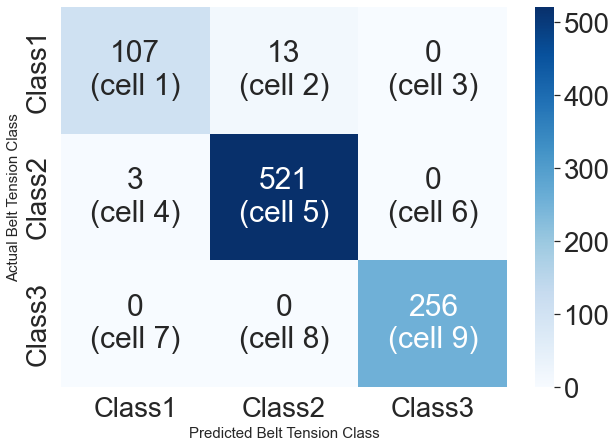

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
y_test=[]
y_predicted =[]
for i in range(1,10):
    df= pd.read_csv(f"./ModelPredections/pred3_{i}.csv")
    y_test.extend(df["Class_3"].to_list())
    y_predicted.extend(df["Pred_BT_Class"].to_list())
print(f"Test: {len(y_test)}")
print(f"Pred: {len(y_predicted)}")
cm = confusion_matrix(y_test, y_predicted)
cm_df = pd.DataFrame(cm,
                     index = ['Class1','Class2','Class3'], 
                     columns = ['Class1','Class2','Class3'])
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
plt.figure(figsize = (10,7))
plt.tight_layout()

group_names=["(cell 1)","(cell 2)","(cell 3)",
        "(cell 4)","(cell 5)","(cell 6)",
        "(cell 7)","(cell 8)","(cell 9)"]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_names)]
labels = np.asarray(labels).reshape(3,3)
sns.set(style='white')
sns.set(font_scale=2.5) # Adjust to fit text in cell
sns.heatmap(cm_df, annot=labels, fmt='', cmap='Blues')

plt.ylabel('Actual Belt Tension Class',fontsize=15)
plt.xlabel('Predicted Belt Tension Class',fontsize=15)
plt.savefig('confusionMat.png', dpi=500)
plt.show()
